In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pickle
import os
plt.style.use('ggplot')

In [2]:
# full_dataset_list = ['sst5', 'trec','agnews', 'financial_phrasebank', 'glue_sst2', \
#                      'rotten_tomatoes', 'subjective', 'tweet_eval_emotion', 'tweet_eval_hate']
full_dataset_list = ['hh-rlhf']

In [3]:
# # Load in result dictionarys

# # Specify a model name 
# model = 'Qwen' # 'Llama', 'Qwen', 'Mistral'
# results_dicts = dict()

# results_dir = '../results' # /path/to/results/folder

# # results_dicts[k] has all the experiment results for k-shots 
# for k in [4,8,16]:
#     results_dict = dict()
#     for dataset_name in full_dataset_list:
#         try:
#             file_path = os.path.join(results_dir,f"results_k_[{k}]_seeds_5_datasets_['{dataset_name}']_models_['{model}']_.pkl")
#             with open(file_path,'rb') as f:
#                 results_dict[dataset_name] = pickle.load(f)
#         except Exception as e:
#             print(e)
#             print(f'Cannot find {dataset_name} for k={k}')
#     results_dicts[k] = results_dict

# # results_dicts structure: results_dicts[4][dataset_name][model_name][results_name][dataset_name_][seed_name]['k'][method_name][metric_name]
# # Example: results_dicts[4]['glue_sst2']['Llama']['results_dic']['GLUE-SST2']['seed_2206632489']['4']['Baseline']['accuracy']

In [4]:
# results_dicts structure: results_dicts[4][dataset_name][model_name][results_name][dataset_name_][seed_name]['k'][method_name][metric_name]
# Example: results_dicts[4]['glue_sst2']['Llama']['results_dic']['GLUE-SST2']['seed_2206632489']['4']['Baseline']['accuracy']
# Combine results for different seeds
RESULTS_DIR = '/hpc/group/fanglab/xx102/ICL/results' # The base directory
MODEL_NAME = 'Qwen'
model = 'Qwen'
K_LIST = [4, 8]
SEED_LIST = [1,321,1234,999,9999]
LAMBDA_VAL = 2 # The lambda value from your filename


def merge_from_specific_paths(k_list, seed_list, model_name, lambda_val, source_dir):
    """
    Merges results using the specific file path format you provided.
    """
    final_results_dict = {}

    for k_shots in k_list:
        for seed in seed_list:
            # Construct the exact file path based on your format
            if k_shots == 4:
                filename = f"result_seed_{seed}_k_{k_shots}.pkl"
            elif k_shots == 8:
                filename = f"result_seed_{seed}_k_{k_shots}_lambda_{lambda_val}.pkl"

            file_path = os.path.join(source_dir, filename)

            if not os.path.exists(file_path):
                print(f"Warning: File not found, skipping - {file_path}")
                continue

            # Load the individual pickle file
            with open(file_path, 'rb') as f:
                data_from_file = pickle.load(f)

            # The code to process the *contents* of the file is the same,
            # as it correctly reflects the internal data structure.
            for dataset_name, seeds_data in data_from_file.items():
                dataset_name_upper = dataset_name.upper()
                for seed_name, k_data in seeds_data.items():
                    for k_value, methods_dict in k_data.items():
                        for method_name, metrics_dict in methods_dict.items():
                            for metric_name, value in metrics_dict.items():

                                # Build the final structure using setdefault
                                target = final_results_dict.setdefault(k_shots, {})\
                                                       .setdefault(dataset_name, {})\
                                                       .setdefault(model_name, {})\
                                                       .setdefault('results_dic', {})\
                                                       .setdefault(dataset_name_upper, {})\
                                                       .setdefault(seed_name, {})\
                                                       .setdefault(k_value, {})\
                                                       .setdefault(method_name, {})

                                # Assign the final value
                                target[metric_name] = value
    return final_results_dict


In [5]:
import pprint

results_dicts = merge_from_specific_paths(
    K_LIST,
    SEED_LIST,
    MODEL_NAME,
    LAMBDA_VAL,
    RESULTS_DIR
)

print("--- Final Merged Dictionary ---")
results_dicts[4]

--- Final Merged Dictionary ---


{'hh-rlhf': {'Qwen': {'results_dic': {'HH-RLHF': {'seed_1': {'4': {'Baseline': {'accuracy': 0.556640625,
        'averaged_truelabel_likelihood': np.float32(0.55546546),
        'macro_F1': 0.5440747845394027,
        'expected_calibration_error_1': np.float32(0.3592936)},
       'CC': {'accuracy': 0.55859375,
        'averaged_truelabel_likelihood': 0.5405002953965732,
        'macro_F1': 0.5556033489515324,
        'expected_calibration_error_1': 0.26795738157559457},
       'Domain': {'accuracy': 0.5546875,
        'averaged_truelabel_likelihood': np.float32(0.5556252),
        'macro_F1': 0.544654559071335,
        'expected_calibration_error_1': np.float32(0.3577505)},
       'Batch': {'accuracy': 0.552734375,
        'averaged_truelabel_likelihood': 0.5237658013913606,
        'macro_F1': 0.5444609783862959,
        'expected_calibration_error_1': 0.12092420440704438},
       'LR-1-[148764]': {'accuracy': 0.490234375,
        'averaged_truelabel_likelihood': 0.499996273336206,
  

In [6]:
# Convenient list of datasets for varying k 
k_dataset_lists = {
    4: full_dataset_list,
    8: full_dataset_list,
}
# Complete list of methods: ['Baseline', 'CC', 'Domain', 'Batch', 'LR-average_voting', \
#                            'LR-1-average_voting', 'LR-2-average_voting', 'LR-3-average_voting', ...] 
methods_to_compare = ['Baseline', 'CC', 'Domain', 'Batch', 'LR-average_voting']
# Complete list of metrics: ['accuracy', 'averaged_truelabel_likelihood', 'macro_F1', 'expected_calibration_error_1']
metrics_to_compare = ['accuracy','macro_F1']

In [7]:
def compute_metrics(results_dict, dataset_list, methods, metrics):
    summary = dict()
    for metric in metrics:
        summary[metric] = []
        
        metric_arr = []
        for dataset_name in dataset_list:
            methods_perms = dict()
            for method in methods:
                methods_perms[method] = []
            
            outcomes = results_dict[dataset_name][model]['results_dic']
            outcomes = outcomes[list(outcomes.keys())[0]]
            
            for seed in outcomes:
                outcome = outcomes[seed][list(outcomes[seed].keys())[0]]
                for m in outcome:
                    if m in methods:
                        methods_perms[m].append(outcome[m])
            
            values_to_plot = []
            for method in methods:
                acc_mean = np.mean(np.array([d[metric] for d in methods_perms[method]]))
                acc_var = np.std(np.array([d[metric] for d in methods_perms[method]]))
                values_to_plot.append((acc_mean, acc_var))
            metric_arr.append(values_to_plot)
        
        summary[metric].append(methods)
        # average accuracy over all datasets
        summary[metric].append(np.mean(np.array([[v[0] for v in vs] for vs in metric_arr]),axis=0))
        # average variance over all datasets 
        summary[metric].append(np.mean(np.array([[v[1] for v in vs] for vs in metric_arr]),axis=0)) 

    return summary

In [8]:
# Example Usage of compute_metrics

# Evaluate the average accuracy and variance over all datasets for k=8
perf = compute_metrics(results_dicts[8], k_dataset_lists[8], methods_to_compare, metrics_to_compare)
for metric, outcome in perf.items():
    print(f'performance metric: {metric}')
    print(f'methods: {outcome[0]}')
    print(f'mean: {outcome[1]}')
    print(f'std: {outcome[2]}')

performance metric: accuracy
methods: ['Baseline', 'CC', 'Domain', 'Batch', 'LR-average_voting']
mean: [0.61171875 0.6046875  0.60664063 0.61015625 0.60859375]
std: [0.04644004 0.03433503 0.04512691 0.04427351 0.04022869]
performance metric: macro_F1
methods: ['Baseline', 'CC', 'Domain', 'Batch', 'LR-average_voting']
mean: [0.60689526 0.60301801 0.60231721 0.60720745 0.60231859]
std: [0.04847187 0.03355823 0.04632292 0.04502537 0.04315778]


In [9]:
# Evaluate the average accuracy and variance for a single dataset 'agnews' for k=8
perf_4 = compute_metrics(results_dicts[4], ['hh-rlhf'], methods_to_compare, metrics_to_compare)
perf_8 = compute_metrics(results_dicts[8], ['hh-rlhf'], methods_to_compare, metrics_to_compare)

for metric, outcome in perf_4.items():
    print(f'performance metric: {metric}')
    print(f'methods: {outcome[0]}')
    print(f'mean: {outcome[1]}')
    print(f'std: {outcome[2]}')

performance metric: accuracy
methods: ['Baseline', 'CC', 'Domain', 'Batch', 'LR-average_voting']
mean: [0.59804687 0.59960938 0.59726563 0.59960938 0.553125  ]
std: [0.0406963  0.03805337 0.04116231 0.04188986 0.04650571]
performance metric: macro_F1
methods: ['Baseline', 'CC', 'Domain', 'Batch', 'LR-average_voting']
mean: [0.59015172 0.59803025 0.59010849 0.5946936  0.44494223]
std: [0.04435897 0.03830267 0.04438718 0.04419929 0.12764165]


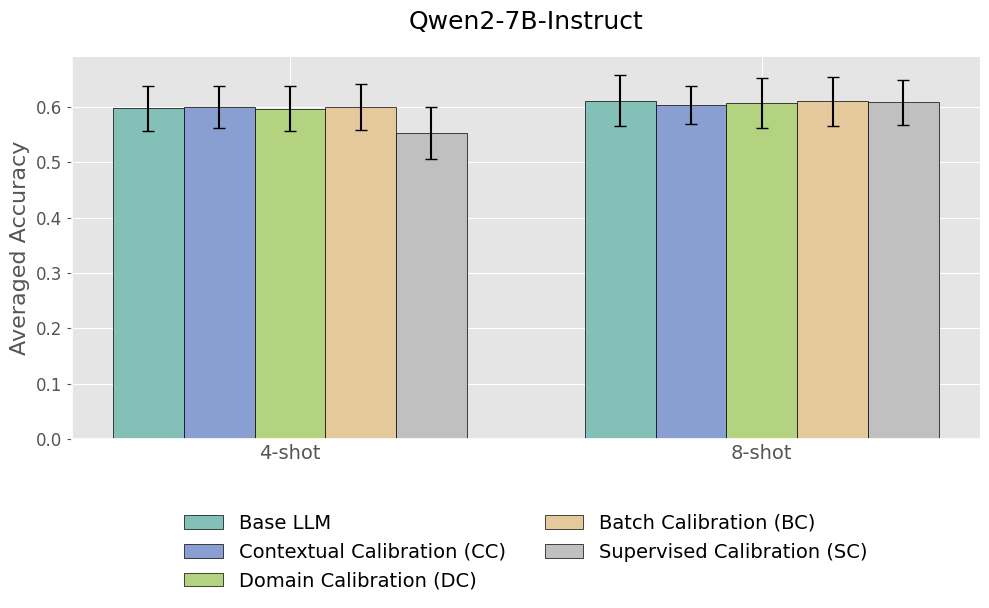

In [10]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['4-shot', '8-shot']

means_base_llm = [perf_4['accuracy'][1][0], perf_8['accuracy'][1][0]]
means_cc = [perf_4['accuracy'][1][1], perf_8['accuracy'][1][1]]
means_domain = [perf_4['accuracy'][1][2], perf_8['accuracy'][1][2]]
means_batch = [perf_4['accuracy'][1][3], perf_8['accuracy'][1][3]]
means_lr = [perf_4['accuracy'][1][4], perf_8['accuracy'][1][4]]

std_base_llm = [perf_4['accuracy'][2][0], perf_8['accuracy'][2][0]]
std_cc = [perf_4['accuracy'][2][1], perf_8['accuracy'][2][1]]
std_domain = [perf_4['accuracy'][2][2], perf_8['accuracy'][2][2]]
std_batch = [perf_4['accuracy'][2][3], perf_8['accuracy'][2][3]]
std_lr = [perf_4['accuracy'][2][4], perf_8['accuracy'][2][4]]

bar_width = 0.15
x = np.arange(len(categories))
pos1 = x - 2 * bar_width
pos2 = x - 1 * bar_width
pos3 = x
pos4 = x + 1 * bar_width
pos5 = x + 2 * bar_width

# 定义颜色
color1 = '#82C0B8' # Base LLM
color2 = '#8A9FD1'
color3 = '#B4D380'
color4 = '#E6C89D' 
color5 = '#C0C0C0'

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(pos1, means_base_llm, bar_width, yerr=std_base_llm, 
       label='Base LLM', color=color1, 
       edgecolor='black', capsize=4)

ax.bar(pos2, means_cc, bar_width, yerr=std_cc,
       label='Contextual Calibration (CC)', color=color2, 
       edgecolor='black', capsize=4)

ax.bar(pos3, means_domain, bar_width, yerr=std_domain,
       label='Domain Calibration (DC)', color=color3,
       edgecolor='black', capsize=4)

ax.bar(pos4, means_batch, bar_width, yerr=std_batch,
       label='Batch Calibration (BC)', color=color4,
       edgecolor='black', capsize=4)

ax.bar(pos5, means_lr, bar_width, yerr=std_lr,
label='Supervised Calibration (SC)', color=color5,
edgecolor='black', capsize=4)

ax.set_ylabel('Averaged Accuracy', fontsize=16)
ax.set_title('Qwen2-7B-Instruct', fontsize=18, pad=20)

ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

ax.tick_params(axis='x', length=0)
ax.tick_params(axis='y', labelsize=12)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
          fancybox=True, shadow=False, ncol=2, fontsize=14, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 1.05])

plt.show()

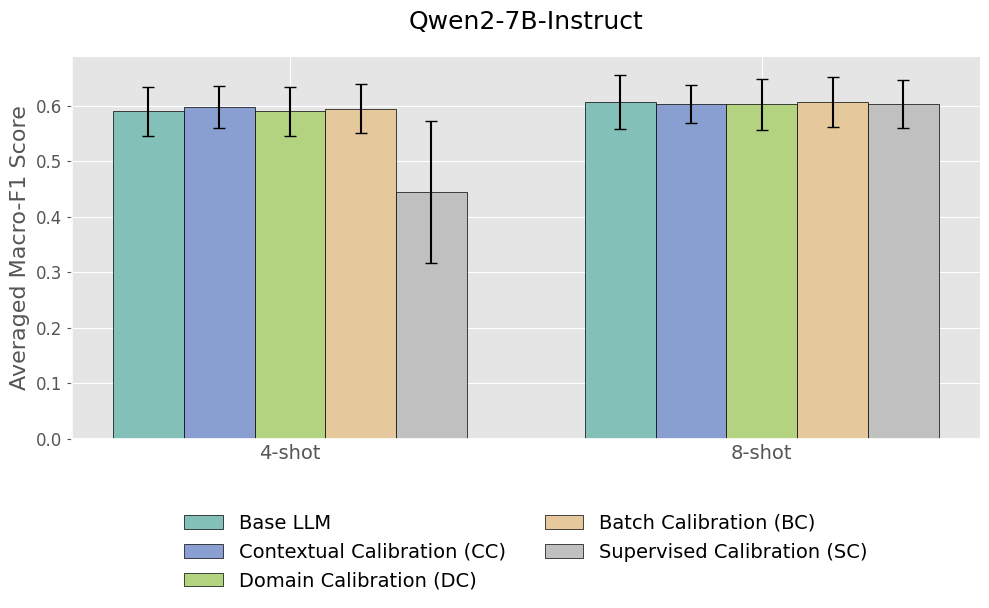

In [11]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['4-shot', '8-shot']

means_base_llm = [perf_4['macro_F1'][1][0], perf_8['macro_F1'][1][0]]
means_cc = [perf_4['macro_F1'][1][1], perf_8['macro_F1'][1][1]]
means_domain = [perf_4['macro_F1'][1][2], perf_8['macro_F1'][1][2]]
means_batch = [perf_4['macro_F1'][1][3], perf_8['macro_F1'][1][3]]
means_lr = [perf_4['macro_F1'][1][4], perf_8['macro_F1'][1][4]]

std_base_llm = [perf_4['macro_F1'][2][0], perf_8['macro_F1'][2][0]]
std_cc = [perf_4['macro_F1'][2][1], perf_8['macro_F1'][2][1]]
std_domain = [perf_4['macro_F1'][2][2], perf_8['macro_F1'][2][2]]
std_batch = [perf_4['macro_F1'][2][3], perf_8['macro_F1'][2][3]]
std_lr = [perf_4['macro_F1'][2][4], perf_8['macro_F1'][2][4]]

bar_width = 0.15
x = np.arange(len(categories))
pos1 = x - 2 * bar_width
pos2 = x - 1 * bar_width
pos3 = x
pos4 = x + 1 * bar_width
pos5 = x + 2 * bar_width

color1 = '#82C0B8'
color2 = '#8A9FD1'
color3 = '#B4D380'
color4 = '#E6C89D'
color5 = '#C0C0C0'

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(pos1, means_base_llm, bar_width, yerr=std_base_llm, 
       label='Base LLM', color=color1, 
       edgecolor='black', capsize=4)

ax.bar(pos2, means_cc, bar_width, yerr=std_cc,
       label='Contextual Calibration (CC)', color=color2, 
       edgecolor='black', capsize=4)

ax.bar(pos3, means_domain, bar_width, yerr=std_domain,
       label='Domain Calibration (DC)', color=color3,
       edgecolor='black', capsize=4)

ax.bar(pos4, means_batch, bar_width, yerr=std_batch,
       label='Batch Calibration (BC)', color=color4,
       edgecolor='black', capsize=4)

ax.bar(pos5, means_lr, bar_width, yerr=std_lr,
label='Supervised Calibration (SC)', color=color5,
edgecolor='black', capsize=4)

ax.set_ylabel('Averaged Macro-F1 Score', fontsize=16)
ax.set_title('Qwen2-7B-Instruct', fontsize=18, pad=20)

ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=14)
# ax.set_ylim(0, 0.85)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

ax.tick_params(axis='x', length=0)
ax.tick_params(axis='y', labelsize=12)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
          fancybox=True, shadow=False, ncol=2, fontsize=14, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 1.05])

plt.show()

## Visualization

In [12]:
def generate_plot(results_dicts_list, dataset_name, methods_to_compare, metrics):
    
    k,n = len(results_dicts_list), len(metrics)
    fig, axes = plt.subplots(nrows=n, ncols=k, figsize=(10*k, 5*n))

    for j, results_dicts in enumerate(results_dicts_list):
        
        methods_perms = dict()
        for method in methods_to_compare[j]:
            methods_perms[method] = []
    
        outcomes = results_dicts[dataset_name][model]['results_dic']
        outcomes = outcomes[list(outcomes.keys())[0]]

        for seed in outcomes:
            outcome = outcomes[seed][list(outcomes[seed].keys())[0]]
            for m in outcome:
                if m in methods_to_compare[j]:
                    methods_perms[m].append(outcome[m])
    
        
        for i, metric in enumerate(metrics):
        
            values_to_plot = []
            for method in methods_to_compare[j]:
                values_to_plot.append(np.mean(np.array([d[metric] for d in methods_perms[method]])))
            axes[i,j].scatter([name if 'LR' not in name else name[:4] for name in methods_to_compare[j] ], values_to_plot)
            axes[i,j].set_title(metric)

In [13]:
methods_to_compare_4 = ['Baseline', 'CC', 'Domain', 'Batch', 'LR-average_voting',\
                        'LR-average_voting','LR-1-average_voting','LR-2-average_voting','LR-3-average_voting']
methods_to_compare_8 = ['Baseline', 'CC', 'Domain', 'Batch', 'LR-average_voting',\
                      'LR-1-average_voting','LR-2-average_voting','LR-3-average_voting','LR-4-average_voting','LR-5-average_voting']
metrics = ['accuracy','averaged_truelabel_likelihood','macro_F1','expected_calibration_error_1']

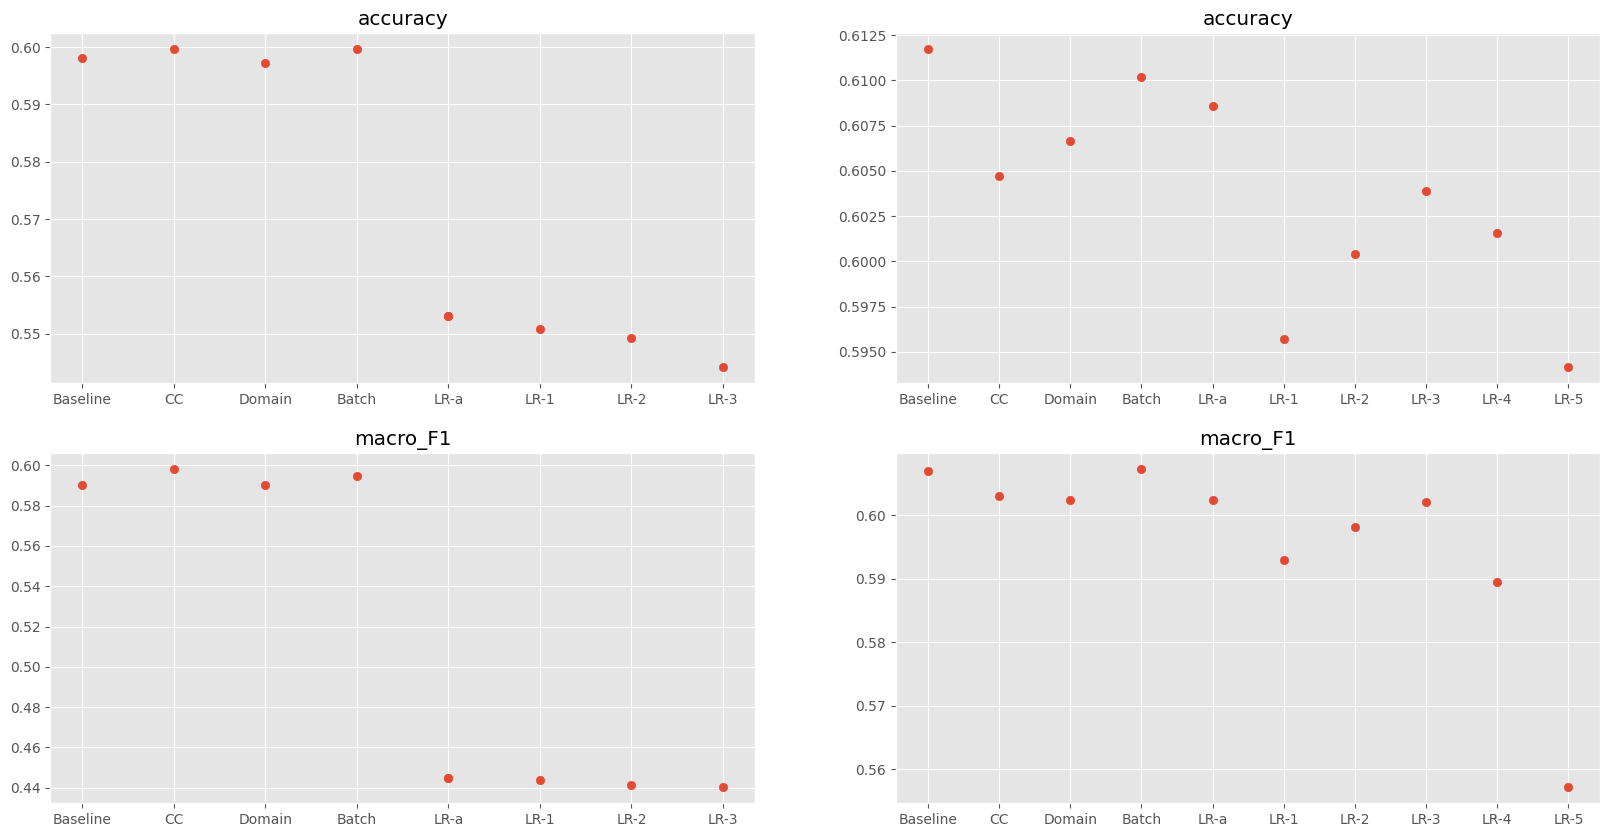

In [14]:
generate_plot([results_dicts[4],results_dicts[8]], 'hh-rlhf', [methods_to_compare_4, methods_to_compare_8], ['accuracy','macro_F1'])

In [15]:
# generate_plot([results_dicts[4],results_dicts[8],results_dicts[16]], 'glue_sst2', [methods_to_compare_4, methods_to_compare_8,methods_to_compare_8], ['accuracy','macro_F1'])

In [16]:
# generate_plot([results_dicts[4],results_dicts[8],results_dicts[16]], 'rotten_tomatoes', [methods_to_compare_4, methods_to_compare_8,methods_to_compare_8], ['accuracy','macro_F1'])

In [17]:
# generate_plot([results_dicts[4],results_dicts[8],results_dicts[16]], 'subjective', [methods_to_compare_4, methods_to_compare_8,methods_to_compare_8], ['accuracy','macro_F1'])

In [18]:
# generate_plot([results_dicts[4],results_dicts[8],results_dicts[16]], 'tweet_eval_emotion', [methods_to_compare_4, methods_to_compare_8,methods_to_compare_8], ['accuracy','macro_F1'])

In [19]:
# generate_plot([results_dicts[4],results_dicts[8],results_dicts[16]], 'tweet_eval_hate', [methods_to_compare_4, methods_to_compare_8,methods_to_compare_8], ['accuracy','macro_F1'])

In [20]:
# generate_plot([results_dicts[4],results_dicts[8],results_dicts[16]], 'financial_phrasebank', [methods_to_compare_4, methods_to_compare_8,methods_to_compare_8], ['accuracy','macro_F1'])

In [21]:
# generate_plot([results_dicts[4],results_dicts[8],results_dicts[16]], 'sst5', [methods_to_compare_4, methods_to_compare_8,methods_to_compare_8], ['accuracy','macro_F1'])

In [22]:
# generate_plot([results_dicts[4],results_dicts[8],results_dicts[16]], 'trec', [methods_to_compare_4, methods_to_compare_8,methods_to_compare_8], ['accuracy','macro_F1'])